In [1]:
!python --version

Python 3.7.10


# Embeddings
- [gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_annoy.html?highlight=load%20word2vec%20txt#work-with-google-s-word2vec-files) - **why do I need it????**
- [tokenizer](https://github.com/google/sentencepiece/blob/master/python/README.md)


## Load data (separate dataset)
- the 2008-2016 dataset 
- python language

In [2]:
!python -c "import tensorflow as tf;print(tf.reduce_sum(tf.random.normal([1000, 1000])))"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'tensorflow'


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks 
from tensorflow.keras import optimizers, models

import sentencepiece as spm

In [3]:
!pip --version

pip 20.1.1 from /Users/alinabogdanova/.pyenv/versions/3.7.10/lib/python3.7/site-packages/pip (python 3.7)


In [386]:
df = pd.read_csv("python_solved.csv")
df = df.drop(columns=["round", "task", "solution", "file", "full_path", "Unnamed: 0.1", "Unnamed: 0", "lang"])

- Let's remove the sort files, then select users with the highest amount of files

- count lines

In [387]:
df["n_lines"] = df.flines.apply(lambda x: str(x).count("\n"))
df["n_lines"].describe()

count    76797.000000
mean        49.785148
std         81.446066
min          0.000000
25%         26.000000
50%         39.000000
75%         60.000000
max       7792.000000
Name: n_lines, dtype: float64

- let's save files with amount of lines in range `[30; 120]`

In [388]:
df = df[(df.n_lines>0)]#&(df.n_lines<=120)]
df.n_lines.describe()

count    76786.000000
mean        49.792280
std         81.449719
min          1.000000
25%         26.000000
50%         39.000000
75%         60.000000
max       7792.000000
Name: n_lines, dtype: float64

- let's find avg file length (in chars)

In [240]:
# df["n_chars"] = df.flines.apply(lambda x: len(str(x)))
# (df.n_chars/df.n_lines).describe()

count    49033.000000
mean        25.356443
std         27.817953
min          9.200000
25%         21.250000
50%         24.287500
75%         27.655172
max       2305.270270
dtype: float64

- suspicious max value let's drop evetyrhing, highter then `100` and look, what's left

In [241]:
# df["chars_per_line"] = df.n_chars/df.n_lines
# df = df[df.chars_per_line<100]
# df.describe()

,year,n_lines,n_chars,chars_per_line
count,48989.000000,48989.000000,48989.000000,48989.000000
mean,2014.167650,55.098287,1374.821429,24.780244
std,2.537077,21.171210,642.735220,5.274674
min,2008.000000,30.000000,358.000000,9.200000
25%,2013.000000,38.000000,902.000000,21.243902
50%,2015.000000,49.000000,1207.000000,24.283019
75%,2016.000000,67.000000,1686.000000,27.643478
max,2017.000000,120.000000,9182.000000,98.937500


- less, then 100 files were removed

## Tokenization
- let's apply embedding to all the source files **LOSE LAYOUT FEATURES**
- * it takes time

Example of lib usage
```python
sp.encode('\tarr = [int(x) for x in str.split()]')
>> [6682, 14, 127, 184, 96091, 96097, 96090, 115, 419, 57, 420, 96084, 1300, 5382]
print(sp.decode(sp.encode('    arr = [int(x) for x in str.split()]')))
>> arr = [int(x) for x in str.split()]
```

In [389]:
sp = spm.SentencePieceProcessor(model_file='embd/sentencepiece_bpe.model')
df.index = np.arange(len(df))
df["n_tokens"] = df.flines.apply(lambda x: len(sp.encode(x)))
df.describe()

,year,n_lines,n_tokens
count,76786.000000,76786.000000,76786.000000
mean,2014.370080,49.792280,340.019248
std,2.464238,81.449719,743.152993
min,2008.000000,1.000000,0.000000
25%,2013.000000,26.000000,167.000000
50%,2015.000000,39.000000,249.000000
75%,2016.000000,60.000000,385.000000
max,2017.000000,7792.000000,36488.000000


- let's set the threshold of 600 tokens here

In [390]:
df = df[df.n_tokens<=600]
df.describe()

,year,n_lines,n_tokens
count,69980.000000,69980.000000,69980.000000
mean,2014.417491,40.930466,259.533138
std,2.444826,20.893534,125.327566
min,2008.000000,1.000000,0.000000
25%,2013.000000,25.000000,161.000000
50%,2015.000000,37.000000,233.000000
75%,2016.000000,53.000000,337.000000
max,2017.000000,265.000000,600.000000


- let's look at the amount of files per participant

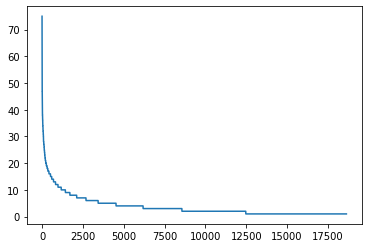

In [392]:
plt.plot(np.array(df.username.value_counts()))

- Let's collect `15` users with avg amount of files, which is around 35
(enough files, but their difference amount is not sufficient)

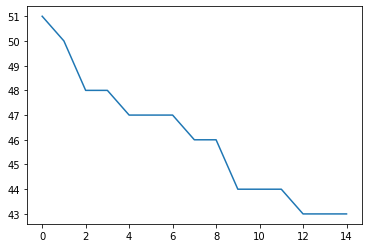

In [395]:
plt.plot(np.array(df.username.value_counts())[5:20])

In [396]:
users = df.username.value_counts()[5:20].index
df = df[df.username.isin(users)]
df.head()

,year,username,flines,n_lines,n_tokens
6,2008,zibada,import sys\n def dbg(a): sys.stderr.write(str(...,40,447
7,2008,zibada,import sys\n def dbg(a): sys.stderr.write(str(...,47,299
8,2008,zibada,import sys\n def dbg(a): sys.stderr.write(str(...,51,345
236,2008,mth,#!/usr/bin/env python\n \n import sys\n \n def...,31,170
237,2008,mth,#!/usr/bin/env python\n \n import sys\n \n def...,43,337


- Let's look at the amount of files per person in more details

In [397]:
df.username.value_counts().describe()

count    15.000000
mean     46.066667
std       2.548576
min      43.000000
25%      44.000000
50%      46.000000
75%      47.500000
max      51.000000
Name: username, dtype: float64

- Hope, this is enough and the contrast between the smallest amount and the max, won't be sufficient

In [398]:
df.username.value_counts()

lidaobing    51
zli          50
Vytis        48
kusano       48
xtof.durr    47
Cypi         47
kawasaki     47
gepa         46
mth          46
Nooodles     44
mihaild      44
zibada       44
JongMan      43
nwin         43
eMBe         43
Name: username, dtype: int64

In [399]:
df["tokens"] = df.flines.apply(lambda x: sp.encode(x))

In [400]:
df.head()

,year,username,flines,n_lines,n_tokens,tokens
6,2008,zibada,import sys\n def dbg(a): sys.stderr.write(str(...,40,447,"[138, 1149, 63, 71605, 96091, 96071, 45, 1149,..."
7,2008,zibada,import sys\n def dbg(a): sys.stderr.write(str(...,47,299,"[138, 1149, 63, 71605, 96091, 96071, 45, 1149,..."
8,2008,zibada,import sys\n def dbg(a): sys.stderr.write(str(...,51,345,"[138, 1149, 63, 71605, 96091, 96071, 45, 1149,..."
236,2008,mth,#!/usr/bin/env python\n \n import sys\n \n def...,31,170,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
237,2008,mth,#!/usr/bin/env python\n \n import sys\n \n def...,43,337,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."


In [401]:
dataset = df[["username", "tokens"]]

In [402]:
dataset

,username,tokens
6,zibada,"[138, 1149, 63, 71605, 96091, 96071, 45, 1149,..."
7,zibada,"[138, 1149, 63, 71605, 96091, 96071, 45, 1149,..."
8,zibada,"[138, 1149, 63, 71605, 96091, 96071, 45, 1149,..."
236,mth,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
237,mth,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
...,...,...
75933,mth,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
76149,zli,"[138, 1149, 63, 1985, 96077, 682, 586, 121, 11..."
76150,zli,"[138, 1149, 156, 5045, 138, 3020, 63, 1985, 96..."
76276,eMBe,"[46, 2860, 96093, 11192, 1109, 156, 321, 2017,..."


## Load data
Lib selected - tensorflow + keras

### Some small notes for future
Tensorflow supports python 3.8 as max version. The issue arises on latest Ubuntu/max os-es, when the default python version is 3.9.

What was done on MAC-OS-Big-Sur to solve that issue.
- [pyenv](https://github.com/pyenv/pyenv) installed
```bash
>> brew update
>> brew install pyenv
...
```
- python 3.7 installation
```
>> brew install python@3.7
```
- pyenv added python 3.7
```
>> pyenv install 3.7.10
>> pyenv loacal 3.7.10
```
- create [myenv](https://www.tensorflow.org/install/pip#2.-create-a-virtual-environment-recommended)
```
>> python3.7 -m venv myenv
>> source myenv/bin/activate.fish
```
- solution of the final problem - **UPGRADE PIP**
- install tensorflow
```
(myenv)>> pip install --upgrade tensorflow
```

In [403]:
le = LabelEncoder()
dataset.username = le.fit_transform(dataset.username)

/Users/alinabogdanova/Documents/workspace/research/myenv/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [404]:
# shuffle dataset
dataset = dataset.sample(frac = 1) 
dataset

,username,tokens
64268,1,"[63, 13778, 96091, 96075, 45, 3764, 14, 420, 9..."
33709,10,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
70441,0,"[178, 96100, 14, 655, 96091, 1032, 96077, 1044..."
59097,11,"[156, 4159, 138, 8485, 63, 13778, 586, 53, 14,..."
42682,0,"[156, 4159, 138, 8485, 178, 96100, 14, 655, 96..."
...,...,...
17764,13,"[63, 13778, 586, 49, 96085, 75, 14, 977, 96091..."
59035,2,"[5059, 9337, 1174, 1250, 144, 9647, 5059, 4474..."
40501,9,"[138, 5045, 138, 6911, 138, 4159, 63, 921, 184..."
33128,2,"[111, 14, 655, 96091, 1032, 96077, 1044, 48938..."


In [405]:
def rsh(x):
    arr = np.array(x)
    arr.resize(600)
    return list(arr)

dataset.tokens = dataset.tokens.apply(rsh)

In [406]:
dataset

,username,tokens
64268,1,"[63, 13778, 96091, 96075, 45, 3764, 14, 420, 9..."
33709,10,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
70441,0,"[178, 96100, 14, 655, 96091, 1032, 96077, 1044..."
59097,11,"[156, 4159, 138, 8485, 63, 13778, 586, 53, 14,..."
42682,0,"[156, 4159, 138, 8485, 178, 96100, 14, 655, 96..."
...,...,...
17764,13,"[63, 13778, 586, 49, 96085, 75, 14, 977, 96091..."
59035,2,"[5059, 9337, 1174, 1250, 144, 9647, 5059, 4474..."
40501,9,"[138, 5045, 138, 6911, 138, 4159, 63, 921, 184..."
33128,2,"[111, 14, 655, 96091, 1032, 96077, 1044, 48938..."


In [407]:
X = dataset.tokens.values
X = np.array(list(X))
X.shape

(691, 600)

In [408]:
X = X.reshape((-1, 600, 1))
y = np.array(dataset.username)

ohe = OneHotEncoder()
y = ohe.fit_transform(y.reshape(-1, 1))
y = y.toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape

(518, 600, 1)

### Structure of the model
1. CNN:
- ks = 50 (function - level)
- ks = 10 (line2 - level)
- ks = 5 (lene - level)
2. Linear ReLU 
3. softmax 75

> important note `tanh` activation increases accuracy from 11% to 60% ontraining (50% of test accuracy)
>
> `linear` function reaches up to 61% of test accuracy

In [409]:
model = keras.Sequential()
model.add(keras.Input(shape=(600, 1)))  
model.add(layers.Conv1D(150, 10, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(15, activation="softmax"))
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_50 (Conv1D)           (None, 591, 150)          1650      
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 73, 150)           0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 10950)             0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 10950)             0         
_________________________________________________________________
dense_88 (Dense)             (None, 64)                700864    
_________________________________________________________________
dropout_65 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_89 (Dense)             (None, 15)              

In [410]:
optimizer = optimizers.Adam(0.1)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_delta=0.000001, verbouse=1)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [411]:
epochs = 100
batch_size = 20
history = model.fit(x=X_train, y=y_train, epochs = epochs, 
                    validation_data = (X_test,y_test),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    verbose=2, 
                    callbacks=[lr_schedule])

Epoch 1/100
25/25 - 1s - loss: 16370291.0000 - accuracy: 0.0830 - val_loss: 13855447.0000 - val_accuracy: 0.0867
Epoch 2/100
25/25 - 0s - loss: 14500130.0000 - accuracy: 0.1660 - val_loss: 12177003.0000 - val_accuracy: 0.1965
Epoch 3/100
25/25 - 0s - loss: 16822834.0000 - accuracy: 0.1873 - val_loss: 13396199.0000 - val_accuracy: 0.1908
Epoch 4/100
25/25 - 0s - loss: 21550338.0000 - accuracy: 0.2104 - val_loss: 21321930.0000 - val_accuracy: 0.2428
Epoch 5/100
25/25 - 0s - loss: 33869340.0000 - accuracy: 0.2645 - val_loss: 46024960.0000 - val_accuracy: 0.2197
Epoch 6/100
25/25 - 0s - loss: 51479608.0000 - accuracy: 0.3012 - val_loss: 62284712.0000 - val_accuracy: 0.3064
Epoch 7/100
25/25 - 0s - loss: 98774760.0000 - accuracy: 0.2529 - val_loss: 109576464.0000 - val_accuracy: 0.2370
Epoch 8/100
25/25 - 0s - loss: 134677456.0000 - accuracy: 0.2876 - val_loss: 152817520.0000 - val_accuracy: 0.2486
Epoch 9/100
25/25 - 0s - loss: 166066960.0000 - accuracy: 0.3398 - val_loss: 219986928.0000 -

In [412]:
def plot_training(history):
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.title("Loss")
    plt.plot(history.history['loss'], color='b', label="Training loss")
    plt.plot(history.history['val_loss'], color='r', label="validation loss")
    plt.legend(loc='best', shadow=True)

    plt.subplot(122)
    plt.title("Accuracy")
    plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
    plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    plt.legend(loc='best', shadow=True)
    return fig

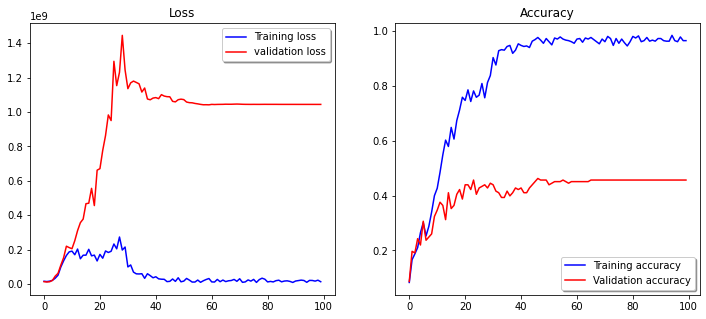

In [413]:
f = plot_training(history)

#### 64% test accuracy

```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(100, 32, activation="linear"))
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### up to 76% test accuracy
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(100, 16, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### converges to 76% test accuracy
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(100, 8, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 77% of test accuracy
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1))) 
model.add(layers.Conv1D(150, 8, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=6))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### confident 81%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(128, 16, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### up to 81.71%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1))) 
model.add(layers.Conv1D(128, 16, activation="linear", strides=2)) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### converges to 80%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(150, 10, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

- Also the structures with 2 Convolutional layers were tested (up to 50% accuracy)
- Avg Pooling works poarly due to the fact, that the initial data is not normalized

In [414]:
from sklearn.metrics import confusion_matrix
import itertools

def plt_conf_matrix(cm, classes):
    cmap=plt.cm.Blues
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
     

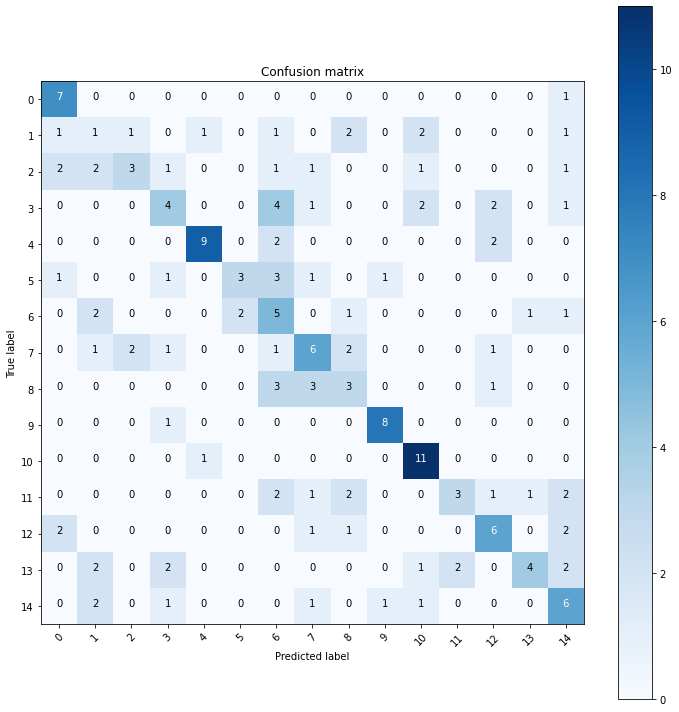

In [415]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
plt_conf_matrix(confusion_mtx, classes = range(15))

In [56]:
model.save('model.h5')

I don't know, what are these ebbeddings, but...

## Let's apply normalization
(thus `relu`, `than` and other activations may be used)

In [416]:
from sklearn.preprocessing import StandardScaler

In [417]:
print(X.min(), X.mean(), X.max())

0 13396.308174143753 99263


As it can be seen, the avg value is far from it's maximum value, thus it is more readonable to apply Standard Scaling

In [418]:
ss = StandardScaler()
X = X.reshape((-1, 600))
X = ss.fit_transform(X)
X = X.reshape((-1, 600, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape

(518, 600, 1)

In [419]:
model = keras.Sequential()
model.add(keras.Input(shape=(600, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Conv1D(32, 4, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(15, activation="softmax"))
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_51 (Conv1D)           (None, 585, 64)           1088      
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 73, 64)            0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 70, 32)            8224      
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 8, 32)             0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 256)               0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 64)              

In [420]:
optimizer = optimizers.Adam(0.01)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_delta=0.000001, verbouse=1)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [421]:
epochs = 100
batch_size = 20
history = model.fit(x=X_train, y=y_train, epochs = epochs, 
                    validation_data = (X_test,y_test),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    verbose=2, 
                    callbacks=[lr_schedule])

Epoch 1/100
25/25 - 1s - loss: 3.2958 - accuracy: 0.0849 - val_loss: 2.7181 - val_accuracy: 0.0809
Epoch 2/100
25/25 - 1s - loss: 2.8095 - accuracy: 0.1197 - val_loss: 2.5354 - val_accuracy: 0.2023
Epoch 3/100
25/25 - 0s - loss: 2.5665 - accuracy: 0.1757 - val_loss: 2.6315 - val_accuracy: 0.1734
Epoch 4/100
25/25 - 0s - loss: 2.5215 - accuracy: 0.1892 - val_loss: 2.4069 - val_accuracy: 0.2254
Epoch 5/100
25/25 - 0s - loss: 2.4757 - accuracy: 0.2278 - val_loss: 2.7365 - val_accuracy: 0.1850
Epoch 6/100
25/25 - 0s - loss: 2.5372 - accuracy: 0.2085 - val_loss: 2.3050 - val_accuracy: 0.2659
Epoch 7/100
25/25 - 0s - loss: 2.4569 - accuracy: 0.2452 - val_loss: 2.3077 - val_accuracy: 0.2717
Epoch 8/100
25/25 - 0s - loss: 2.3370 - accuracy: 0.2722 - val_loss: 2.4233 - val_accuracy: 0.2312
Epoch 9/100
25/25 - 0s - loss: 2.2520 - accuracy: 0.2896 - val_loss: 2.3786 - val_accuracy: 0.2659
Epoch 10/100
25/25 - 0s - loss: 2.2701 - accuracy: 0.3012 - val_loss: 2.5001 - val_accuracy: 0.2428
Epoch 11/

#### 80% accuracy (previous model)
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(150, 10, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 82%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(128, 16, activation="tanh"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 86% up to 87%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Conv1D(32, 4, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 84%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Conv1D(32, 4, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```
#### 84%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.AveragePooling1D(pool_size=8))
model.add(layers.Conv1D(32, 8, activation="linear")) 
model.add(layers.AveragePooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 83%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(128, 16, activation="relu"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

In [87]:
model.save('86_model.h5')

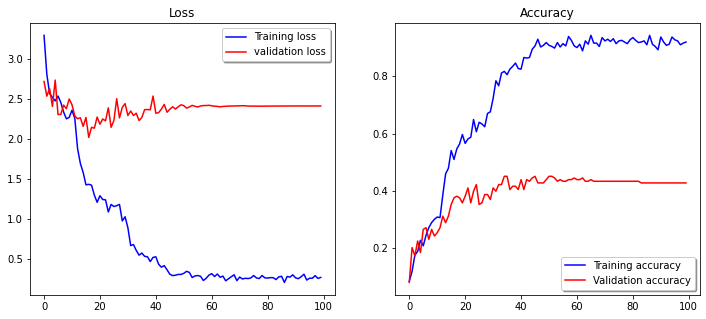

In [422]:
f = plot_training(history)

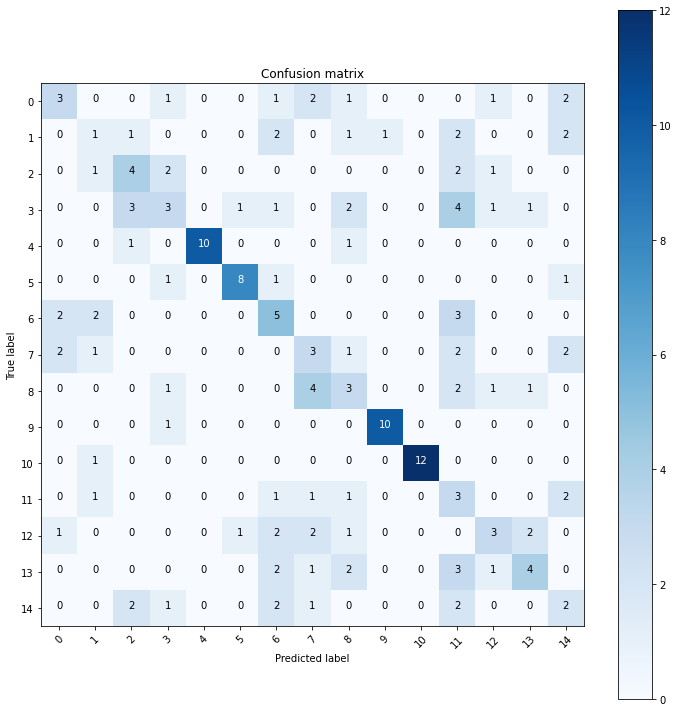

In [423]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
plt_conf_matrix(confusion_mtx, classes = range(15))

## Triplet loss
- useful [link1](https://zhangruochi.com/Create-a-Siamese-Network-with-Triplet-Loss-in-Keras/2020/08/11/ ), [link2](https://codepad.co/snippet/triplet-loss-in-keras-tensorflow-backend)

### Main idea (If I understood correctly)
- create embedding for embeddings (?)
- apply KNN to find the closest vectors - if the problem is related to the classification

### Data preprocessing flow:
1. Split X[-1, 500] on pices of [-1, 100] and increase the dimensionality of array
2. Shuffle ???
3. Create batch_loader:
        3.1. Select anchor samples (**TODO** search if it is usually done sequentially or randomly)
        3.2. Select some X, where y is the same (random or sequential???)
        3.3. Select some X, where y is different (random or sequential???)
4. Create model (e.g. Sequential)
5. Concatenate 3 models for anchor, positives an negatives // this is exactly the parallel convolution, which I was searching during the previous stages
6. Create a functions `loss` and `data_generator`
7. Train model with dummy y (e.g 0) ([good example](https://github.com/AdrianUng/keras-triplet-loss-mnist#visualizing-separation-of-classes ), [their code](https://github.com/AdrianUng/keras-triplet-loss-mnist/blob/master/Triplet_loss_KERAS_semi_hard_from_TF.ipynb))
8. Apply the visualization with PCA/test on KNN????

### Make samples smaller, e.g. 100
- potential problem - files are ended with zeros, if amount of tokens is less


In [424]:
def crop_to(X, y, crop=100, threshold=80):
    new_X = []
    new_y = []
    for old_x, old_y in zip(X, y):
        for el in old_x.reshape(-1, 100):
            if(np.count_nonzero(el) > 80):
                new_X.append(list(el))
                new_y.append(np.argmax(old_y))
    
    new_X = np.array(new_X).reshape(-1, crop, 1)
    new_y = np.array(new_y)
    return new_X, new_y

# new_X, new_y = crop_to(X, y)
new_X, new_y = X, np.argmax(y, axis=1)

In [425]:
new_X.shape

(691, 600, 1)

In [426]:
data_length = new_y.shape[0]

### Shuffle - do I need this?
- No, because in the batch I'm going to use random

### Batch generation

In [427]:
def batch_generator(X, y):
    
    data_length = X.shape[0]
    index = np.random.randint(data_length)
    anchor, anchor_y = X[index], y[index]
    
    positive = X[np.random.choice(np.where(y==anchor_y)[0])]
    negative = X[np.random.choice(np.where(y!=anchor_y)[0])]
    
    return [list(anchor), list(positive), list(negative)]

def batches_generator(X, y, batch_size=32):
    '''
    Array of batch_generator results
    
    batch_size - size of the generated array
    '''
    all_data = np.array([batch_generator(X, y) for i in range(batch_size)])
    anchors = all_data[:, 0, :]
    positives = all_data[:, 1, :]
    negatives = all_data[:, 2, :]
    return anchors, positives, negatives

def data_generator(X, y, batch_size=32, input_size=600):
    while True:
        batch = batches_generator(X, y, batch_size)
        labels = np.zeros((batch_size, input_size*3)) 
        yield batch, labels
        


### Model creation


- let's repeat the best arch

In [428]:
import tensorflow as tf
from tensorflow.keras import regularizers


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [429]:
params = {
    "activations" : ["tanh", "relu", "elu", "sigmoid", "linear", "selu", "gelu", "swish"],
    #"output_sizes" : [50, 100, 500],
    "L2_lambda": [0.01, 0.001, 0.0001],
    "pool_1_size": [4, 8],
    "pool_2_size":[4, 8],
    "conv_1_size": [16, 32, 64],
    "conv_2_size":[4, 8],
    "dense_1": [64]   
}
params = {
    "activations" : ["relu"],
    #"output_sizes" : [50, 100, 500],
    "L2_lambda": [0.001],
    "pool_1_size": [4, 8],
    "pool_2_size":[4, 8],
    "conv_1_size": [8, 16],
    "conv_2_size":[4, 8],
    "dense_1": [64]   
}

In [430]:
new_X.shape, new_y.shape

((691, 600, 1), (691,))

In [431]:
output_size = 50
input_size = 600

In [432]:
def create_model(activation="linear", L2_lambda=0.02, 
                 pool_1_size=4, pool_2_size=4, 
                 conv_1_size=16, conv_2_size=4, dense_1=64):
    
    model_core = keras.Sequential()
    model_core.add(layers.Conv1D(64, conv_1_size, 
                                 activation=activation, 
                                 kernel_regularizer=regularizers.L2(L2_lambda)))
    
    model_core.add(layers.LayerNormalization(axis=1))
    model_core.add(layers.MaxPooling1D(pool_size=pool_1_size))
    
    model_core.add(layers.Conv1D(32, conv_2_size, 
                                 activation=activation, 
                                 kernel_regularizer=regularizers.L2(L2_lambda)))

    model_core.add(layers.LayerNormalization(axis=1))
    model_core.add(layers.MaxPooling1D(pool_size=pool_2_size))
    
    model_core.add(layers.Flatten())
    model_core.add(layers.Dropout(0.5))
    model_core.add(layers.Dense(dense_1, activation=activation, 
                                kernel_regularizer=regularizers.L2(L2_lambda)))
    model_core.add(layers.LayerNormalization(axis=1))
    
    model_core.add(layers.Dropout(0.5))
    model_core.add(layers.Dense(output_size, activation=activation, 
                                kernel_regularizer=regularizers.L2(L2_lambda)))
    model_core.add(layers.LayerNormalization(axis=1))
    return model_core


In [433]:
def triplet_loss(y_true, y_pred):
    alpha = 0.2
    y_pred = tf.convert_to_tensor(y_pred)
    global output_size
    anchor = y_pred[:, :output_size]
    positive = y_pred[:, output_size:2*output_size]
    negative = y_pred[:, 2*output_size:]
    
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)

    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

In [434]:
def create_triplet_model(input_size, model_core):
    
    input_anchor = layers.Input(shape=(input_size, 1))
    input_positive = layers.Input(shape=(input_size, 1))
    input_negative = layers.Input(shape=(input_size, 1))

    model_anchor = model_core(input_anchor)
    model_positive = model_core(input_positive)
    model_negative = model_core(input_negative)

    result = layers.concatenate([model_anchor, model_positive, model_negative], axis=1)
    model = models.Model([input_anchor, input_positive, input_negative], result)
    return model


In [435]:
def train(new_X, new_y, input_size, model):
    batch_size = 64
    epochs = 100
    steps_per_epoch = int(new_X.shape[0]/batch_size)

    optimizer = optimizers.Adam(0.1)
    lr_schedule = callbacks.ReduceLROnPlateau(monitor='loss', actor=0.5, patience=2, min_delta=0.000001, verbouse=1)
    early_stopping = callbacks.EarlyStopping(monitor="loss", min_delta = 0.0001, patience=5, restore_best_weights=True)

    model.compile(loss=triplet_loss, optimizer=optimizer)
    history = model.fit(data_generator(new_X, new_y, batch_size, input_size),
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs, 
                        verbose=0, 
                        callbacks=[lr_schedule, early_stopping])
    return model, history


In [436]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [437]:
def test(model_core, new_X, new_y):
    transformed_X = model_core.predict(new_X.reshape(-1, input_size, 1))
    X_train, X_test, y_train, y_test = train_test_split(transformed_X, new_y)
    
   
    knn = KNeighborsClassifier(n_neighbors=3, algorithm="ball_tree", weights="distance")
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    score = accuracy_score(y_test, y_pred)
    
    return score

In [438]:
param_list = []
for key in params.keys():
    if len(param_list)==0:
        for x in params[key]:
            param_list.append([x])
    else:
        new_param_list = []
        for l in param_list:
            for x in params[key]:
                l_copy = l.copy()
                l_copy.append(x)
                new_param_list.append(l_copy)
        param_list = new_param_list
len(param_list)

16

In [439]:
param_list[0]

['relu', 0.001, 4, 4, 8, 4, 64]

In [440]:
import tqdm

In [441]:
max_score = 0
best_model = None
log = []
core_model = None
for p in tqdm.tqdm(param_list):
    core_model = create_model(*p)
    triplet = create_triplet_model(input_size, core_model)
    model, history = train(new_X, new_y, input_size, triplet)
    score = test(core_model, new_X, new_y)
    if score > max_score:
        max_score = score
        best_model = model
        print(p, score)
    log.append({"score": score, "history": history, "params": p})


  6%|▋         | 1/16 [02:02<30:43, 122.92s/it]

['relu', 0.001, 4, 4, 8, 4, 64] 0.12716763005780346


 12%|█▎        | 2/16 [03:27<23:26, 100.45s/it]

['relu', 0.001, 4, 4, 8, 8, 64] 0.13872832369942195


 38%|███▊      | 6/16 [07:05<09:31, 57.10s/it] 

['relu', 0.001, 4, 8, 8, 8, 64] 0.14450867052023122


 56%|█████▋    | 9/16 [11:40<09:09, 78.53s/it]

['relu', 0.001, 8, 4, 8, 4, 64] 0.16184971098265896


100%|██████████| 16/16 [17:56<00:00, 67.25s/it]


In [324]:
print(len(log))

16


In [325]:
log_df = pd.DataFrame(log)

In [326]:
log_df

,score,history,params
0,0.136691,<tensorflow.python.keras.callbacks.History obj...,"[relu, 0.001, 4, 4, 8, 4, 64]"
1,0.136691,<tensorflow.python.keras.callbacks.History obj...,"[relu, 0.001, 4, 4, 8, 8, 64]"
2,0.172662,<tensorflow.python.keras.callbacks.History obj...,"[relu, 0.001, 4, 4, 16, 4, 64]"
3,0.323741,<tensorflow.python.keras.callbacks.History obj...,"[relu, 0.001, 4, 4, 16, 8, 64]"
4,0.165468,<tensorflow.python.keras.callbacks.History obj...,"[relu, 0.001, 4, 8, 8, 4, 64]"
5,0.136691,<tensorflow.python.keras.callbacks.History obj...,"[relu, 0.001, 4, 8, 8, 8, 64]"
6,0.223022,<tensorflow.python.keras.callbacks.History obj...,"[relu, 0.001, 4, 8, 16, 4, 64]"
7,0.172662,<tensorflow.python.keras.callbacks.History obj...,"[relu, 0.001, 4, 8, 16, 8, 64]"
8,0.093525,<tensorflow.python.keras.callbacks.History obj...,"[relu, 0.001, 8, 4, 8, 4, 64]"
9,0.172662,<tensorflow.python.keras.callbacks.History obj...,"[relu, 0.001, 8, 4, 8, 8, 64]"


In [327]:
log_df["history_arr"] = log_df.history.apply(lambda x: x.history["loss"])

In [328]:
log_df["activations"] = log_df.params.apply(lambda x:x[0])
log_df["L2_lambda"]  = log_df.params.apply(lambda x:x[1])
log_df[ "pool_1_size"] = log_df.params.apply(lambda x:x[2])
log_df[ "pool_2_size"] = log_df.params.apply(lambda x:x[3])
log_df["conv_1_size"] = log_df.params.apply(lambda x:x[4])
log_df["conv_2_size"] = log_df.params.apply(lambda x:x[5])
log_df["dense_1"] = log_df.params.apply(lambda x:x[6])

In [329]:
log_df = log_df.drop(columns=["history", "params"])

In [330]:
log_df.score.describe()

count    16.000000
mean      0.165018
std       0.055196
min       0.093525
25%       0.136691
50%       0.169065
75%       0.176259
max       0.323741
Name: score, dtype: float64

#### All the tame accuracy was approximately the same

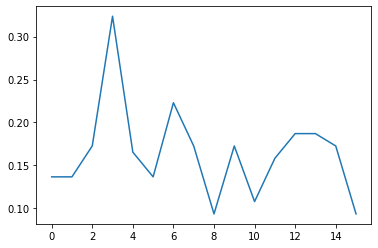

In [331]:
plt.plot(log_df.score)

### How the best model was trained?

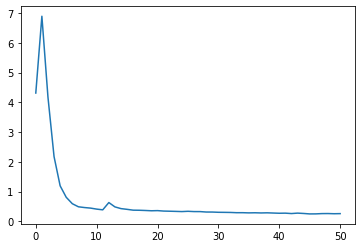

In [371]:
plt.plot(log_df.history_arr[3])

In [333]:
log_df.to_csv("grid_6.csv")

In [334]:
log_df.to_json("grid_6.json")# arrays could be exported better (history)

-  52% - 20-40 by amount of files, 600 input - 100 output
-  53% - 20-40 by amount of files, 600 input - 200 output
-  53% - 20-40 by amount of files, 600 input - 400 output
- 33% - 20-40 by amount of files, 100 input - 100 output
-  49.7% - 0-40 by amount of files, 600 input - 100 output

### Read more
- [implementation by tensorflow](https://www.tensorflow.org/addons/tutorials/losses_triplet)

## What's going on!?
Why the accuracy is so low! Let's look at the PCA of the daataset

In [335]:
import numpy as np
from sklearn.decomposition import PCA

In [336]:
# pass the data through the model

In [337]:
vectorized_X = core_model.predict(new_X)

In [338]:
vectorized_X.shape

(556, 50)

In [339]:
pca = PCA(n_components=3)

In [340]:
pca.fit(vectorized_X)

PCA(n_components=3)

In [341]:
pca_x = pca.transform(vectorized_X)

In [342]:
pca_x.shape

(556, 3)

In [347]:
y1d = new_y
# y1d = np.argmax(new_y, axis=1)

In [350]:
pca_x[np.where(y1d==0), 0]

array([[ 1.7652576 ,  1.7969167 ,  1.7108258 ,  0.8462425 ,  1.79191   ,
         1.7723073 ,  1.7566134 ,  1.7595161 ,  1.7924966 , -1.4870523 ,
         1.7969167 ,  1.7966443 ,  1.5209836 , -1.4434018 ,  1.7880903 ,
         1.7946037 ,  0.04005579,  0.44772303,  1.4355172 ,  1.6830665 ,
         1.8048829 , -1.5411042 ,  1.7882164 ,  1.7909865 , -1.5408669 ,
         1.7834002 ,  1.7908866 ,  0.03174303, -0.31782928,  1.6932625 ,
         1.677132  , -1.5323657 ,  1.6906624 ,  1.8019091 ]],
      dtype=float32)

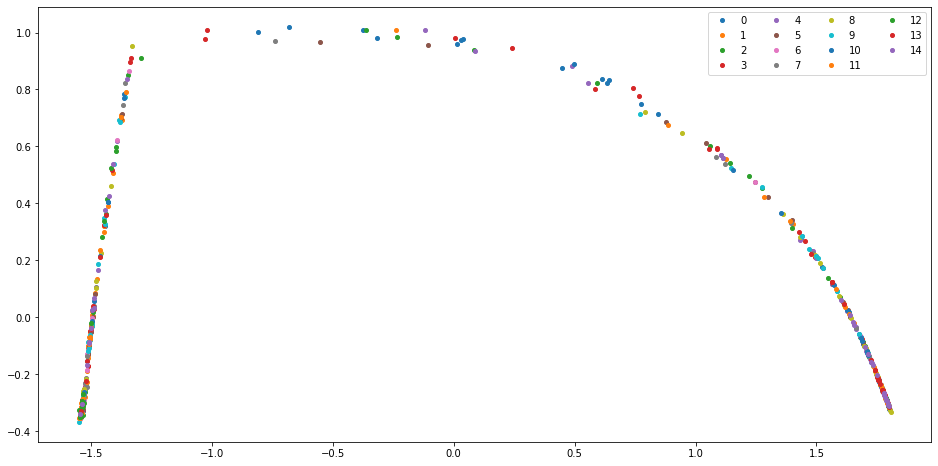

In [354]:
plt.figure(figsize=(16, 8))
for i in range(15):
    plt.plot(pca_x[np.where(y1d==i), 0][0], pca_x[np.where(y1d==i), 1][0], 'o', ms=4, label=str(i))
plt.legend(ncol=4)

Before
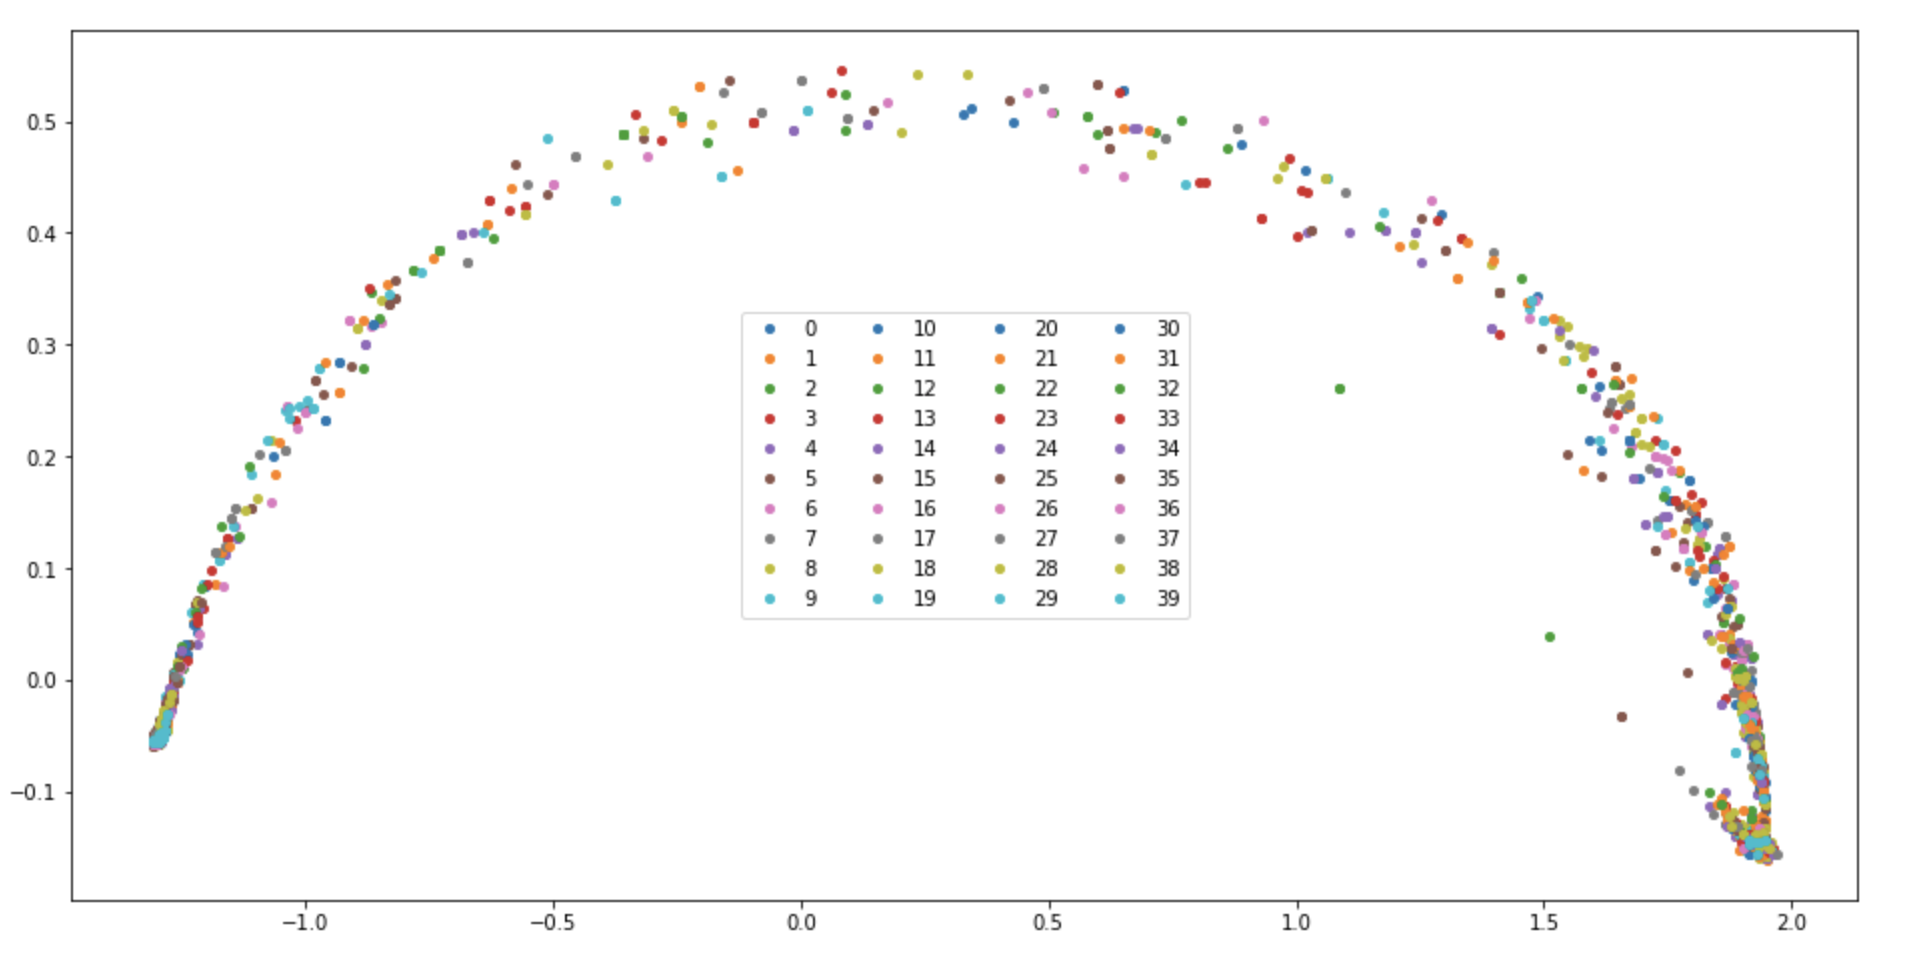

### Ok... Let's train the model on the top of the embeddings

In [355]:
new_y
ohe = OneHotEncoder()
new_y = ohe.fit_transform(new_y.reshape(-1, 1))
new_y = new_y.toarray()

In [376]:
classifier = keras.Sequential()
classifier.add(layers.Input((1, 50)))
classifier.add(layers.Dense(128, activation="linear"))
classifier.add(layers.LayerNormalization(axis=1))
classifier.add(layers.Dropout(0.5))
classifier.add(layers.Dense(64, activation="linear"))
classifier.add(layers.LayerNormalization(axis=1))
classifier.add(layers.Dropout(0.5))
classifier.add(layers.Dense(15, activation="softmax"))

In [377]:
vectorized_X.shape

(556, 50)

In [378]:
new_y.shape

(556, 15)

In [379]:
batch_size = 64
epochs = 100
steps_per_epoch = int(vectorized_X.shape[0]/batch_size)

optimizer = optimizers.Adam(0.1)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='loss', actor=0.5, patience=2, min_delta=0.000001, verbouse=1)
early_stopping = callbacks.EarlyStopping(monitor="loss", min_delta = 0.0001, patience=5, restore_best_weights=True)


classifier.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])
history = classifier.fit(x=vectorized_X, y=new_y, epochs = epochs, 
                        validation_data = (vectorized_X,new_y),
                        steps_per_epoch=vectorized_X.shape[0] // batch_size,
                        verbose=2, 
                        callbacks=[lr_schedule, early_stopping])

Epoch 1/100
8/8 - 1s - loss: 4.1786 - accuracy: 0.0665 - val_loss: 2.7677 - val_accuracy: 0.1007
Epoch 2/100
8/8 - 0s - loss: 2.8550 - accuracy: 0.0791 - val_loss: 3.0864 - val_accuracy: 0.0737
Epoch 3/100
8/8 - 0s - loss: 2.9546 - accuracy: 0.0647 - val_loss: 2.7966 - val_accuracy: 0.0755
Epoch 4/100
8/8 - 0s - loss: 2.8099 - accuracy: 0.0558 - val_loss: 2.7181 - val_accuracy: 0.0755
Epoch 5/100
8/8 - 0s - loss: 2.7436 - accuracy: 0.0629 - val_loss: 2.7409 - val_accuracy: 0.0737
Epoch 6/100
8/8 - 0s - loss: 2.7385 - accuracy: 0.0629 - val_loss: 2.7065 - val_accuracy: 0.0647
Epoch 7/100
8/8 - 0s - loss: 2.7214 - accuracy: 0.0683 - val_loss: 2.7080 - val_accuracy: 0.1043
Epoch 8/100
8/8 - 0s - loss: 2.7212 - accuracy: 0.0701 - val_loss: 2.7091 - val_accuracy: 0.0737
Epoch 9/100
8/8 - 0s - loss: 2.7142 - accuracy: 0.0647 - val_loss: 2.7036 - val_accuracy: 0.0719
Epoch 10/100
8/8 - 0s - loss: 2.7114 - accuracy: 0.0809 - val_loss: 2.7040 - val_accuracy: 0.0737
Epoch 11/100
8/8 - 0s - loss:

- [x] Plot data with PCA
- [x] Train more sophisticated classifier
- [ ] Look at the data with errors - nope... too much encodings and normalizations to transform it back
- [x] Classification of the other question
- [ ] Parallell training
- [x] Change the data selection process
- [ ] Start conv2d embeddings
- [ ] Change the generation process of the triplets

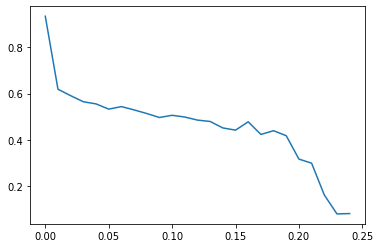

In [364]:
def test(model_core, new_X, new_y, threshold=0.2, printing=0):
    transformed_X = model_core.predict(new_X.reshape(-1, input_size, 1))
    X_train, X_test, y_train, y_test = train_test_split(transformed_X, new_y)
    
    y_pred = []
    y_true = []
    for i in range(X_test.shape[0]):
        for j in range(i, X_test.shape[0]):
            if np.mean((X_test[i] - X_test[j])**2) <= threshold:
                y_pred.append(1)
            else:
                y_pred.append(0)
            
            if y_test[i] == y_test[j]:
                y_true.append(1)
            else:
                y_true.append(0)
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    score = accuracy_score(y_true, y_pred)
    if printing:
        print(confusion_matrix(y_true, y_pred))
        print(sum(y_pred), sum(y_true), y_true.shape)
    
    return score
    

scores = [test(core_model, new_X, np.argmax(new_y, axis=1), k) for k in np.arange(0, 0.25, 0.01) ]
plt.plot(np.arange(0, 0.25, 0.01), scores)

In [365]:
## As it can be seen, the accuracy is still around 50% in the best meaningfull cases 
## Despite the low values on KNN, threshold approximation works good (even a bit better)

Some more links
- signature recognition with [triplet loss](https://github.com/jadevaibhav/Signature-verification-using-deep-learning/blob/master/mycode.ipynb)
- 

Whhen the dataset changed, the accuracy dropped drammatically, however, the visualization performed better